In [1]:
# 1. EDA
# 2. Simple solutions
# 3. Features generation
# 3. Text vectorization
# 4. xgboost && catboost
# 5. parameters selection (grid search) <- best result
# 6. ensembling
# 7. NN experiments

import xgboost
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from itertools import product
import gc

In [2]:
item_categories = pd.read_csv('../readonly/final_project_data/item_categories.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')

dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_train = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz', parse_dates=['date'], date_parser=dateparse)

sample_submission = pd.read_csv('../readonly/final_project_data/sample_submission.csv')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
test = pd.read_csv('../readonly/final_project_data/test.csv')

In [3]:
print("item_categories shape {}".format(item_categories.shape))
item_categories.head()

item_categories shape (84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
item_categories.item_category_name.head(100)

0                      PC - Гарнитуры/Наушники
1                             Аксессуары - PS2
2                             Аксессуары - PS3
3                             Аксессуары - PS4
4                             Аксессуары - PSP
5                          Аксессуары - PSVita
6                        Аксессуары - XBOX 360
7                        Аксессуары - XBOX ONE
8                               Билеты (Цифра)
9                              Доставка товара
10                       Игровые консоли - PS2
11                       Игровые консоли - PS3
12                       Игровые консоли - PS4
13                       Игровые консоли - PSP
14                    Игровые консоли - PSVita
15                  Игровые консоли - XBOX 360
16                  Игровые консоли - XBOX ONE
17                    Игровые консоли - Прочие
18                                  Игры - PS2
19                                  Игры - PS3
20                                  Игры - PS4
21           

In [5]:
print("items shape {}".format(items.shape))
items.head() 

items shape (22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
def extract_category_type(line):
    line_preprocessed = gensim.utils.simple_preprocess(line)
    return line_preprocessed[0]

item2id = {}
def gen_id(line):
    if line in item2id:
        return item2id[line]
    else:
        i = len(item2id.keys())
        item2id[line] = i
        return i

# wtf = item_categories.copy()

#item_categories['item_category_type'] = item_categories['item_category_name'].apply(extract_category_type)
#item_categories['item_category_type_id'] = item_categories['item_category_type'].apply(gen_id)
#item_categories.head(100)

In [7]:
print("date_block_num.max() {}".format(sales_train.date_block_num.max()))
print("item_id.unique() {}".format(sales_train.item_id.unique()))
print("count item_id.unique() {}".format(len(sales_train.item_id.unique())))
print("count date.unique() {}".format(len(sales_train.date.unique())))
print("count shop_id.unique() {}".format(len(sales_train.shop_id.unique())))
print("train shape {}".format(sales_train.shape))
sales_train.head()

date_block_num.max() 33
item_id.unique() [22154  2552  2554 ...  7610  7635  7640]
count item_id.unique() 21807
count date.unique() 1034
count shop_id.unique() 60
train shape (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [8]:
sales_train.date.max()

Timestamp('2015-10-31 00:00:00')

In [9]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [10]:
print("shops shape {}".format(shops.shape))
shops.head()

shops shape (60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
shops.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

In [12]:
# Cleanup duplicates

# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [13]:
def extract_city_name(line):
    line_preprocessed = gensim.utils.simple_preprocess(line)
    return line_preprocessed[0]

city2id = {}
def gen_id(line):
    if line in city2id:
        return city2id[line]
    else:
        i = len(city2id.keys())
        city2id[line] = i
        return i

# shops = shops.copy()

#shops['city_name'] = shops['shop_name'].apply(extract_city_name)
#shops['city_id'] = shops['city_name'].apply(gen_id)
#shops.head(100)

In [14]:

print("test shape {}".format(test.shape))
test.head()

test shape (214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
def make_submission(y_pred, id_column, filename):
    result = pd.DataFrame({"ID": id_column, "item_cnt_month": y_pred})
    result.to_csv(filename, index=False)
        
def make_submission2(X_test, y_pred, test, filename):
    X_test = X_test.copy()
    if 'ID' in X_test.columns:
        X_test = X_test.drop(columns=['ID'])
    X_test['item_cnt_month'] = y_pred    
    X_test = pd.merge(left=X_test, right=test, on=['shop_id', 'item_id'])
    result = X_test[['ID', 'item_cnt_month']]
    
    result.to_csv(filename, index=False)

In [16]:
def trivial_solution_0(train, test, y_true):
    last_month_no=train.date_block_num.max()
    monthly = train[train.date_block_num == last_month_no]
    monthly = monthly.drop(columns=["date_block_num", "date", "item_price"])
    monthly = monthly.groupby(["shop_id","item_id"]).agg({"item_cnt_day":"sum"}) #.reset_index()
    
    y_pred = np.zeros(len(test.shop_id.values))
    i = 0

    for index, row in test.iterrows():
        key = (row.shop_id, row.item_id)
        result = 0.0
        if monthly.index.contains(key):
            result = monthly.loc[key]["item_cnt_day"]

        y_pred[i] = result
        
        i = i + 1

    y_pred = np.clip(y_pred, 0, 20)

    if y_true is not None:    
        #print(y_pred)
        #print(y_true)
        mse = mean_squared_error(y_true, y_pred)
        print(math.sqrt(mse))

    return y_pred

In [17]:
X_train=sales_train[sales_train.date_block_num <= 32].copy()

X_test=sales_train[sales_train.date_block_num == 33].drop(columns=["date_block_num", "date", "item_price"])
X_test=X_test.groupby(["shop_id", "item_id"]).agg({"item_cnt_day": "sum"}).reset_index().copy()

y_test=X_test.item_cnt_day

X_test=X_test.drop(columns=["item_cnt_day"])

trivial_solution_0(X_train, X_test, y_test)

14.379813727817279


array([0., 1., 0., ..., 3., 1., 0.])

In [18]:
# print(sales_train.groupby(["shop_id", "item_id"], as_index=False).agg({"item_cnt_day": "sum"}).shape)

print(sales_train.groupby(["shop_id", "item_id"], as_index=False).agg({"item_cnt_day": "sum"}).shape)
print(shops.shape[0] * items.shape[0])

print(X_test.shape)
print(test.shape)
test.drop(columns=['ID']).drop_duplicates().shape

sales_train[sales_train.date_block_num.isin([9, 21, 33])].groupby(["shop_id", "item_id"], as_index=False).agg({"item_cnt_day": "sum"}).shape

(418909, 3)
1330200
(31531, 2)
(214200, 3)


(108807, 3)

In [19]:
y_pred=trivial_solution_0(sales_train, test, None)

In [20]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [21]:
# scores 1.167778 and 1.172726

make_submission2(test, y_pred, test, "submission_0.csv")

In [22]:
# use 2 last months
def trivial_solution_0_1(train, test, y_true, prev_months_cnt):
    m = len(train.date_block_num.values)
    prev_months = train.date_block_num.values[m-prev_months_cnt:]
    monthly = train[train.date_block_num.isin(prev_months)]
    monthly = monthly.drop(columns=["date_block_num", "date", "item_price"])
    monthly = monthly.groupby(["shop_id","item_id"]).agg({"item_cnt_day":"sum"}) #.reset_index()
    
    monthly["item_cnt_day"] = monthly["item_cnt_day"].div(prev_months_cnt)
    
    y_pred = np.zeros(len(test.shop_id.values))
    i = 0

    for index, row in test.iterrows():
        key = (row.shop_id, row.item_id)
        result = 0.0
        if monthly.index.contains(key):
            result = monthly.loc[key]["item_cnt_day"]

        y_pred[i] = result
        
        i = i + 1

    y_pred = np.clip(y_pred, 0, 20)

    if y_true is not None:    
        #print(y_pred)
        #print(y_true)
        mse = mean_squared_error(y_true, y_pred)
        print(math.sqrt(mse))

    return y_pred

In [23]:
trivial_solution_0_1(X_train, X_test, y_test, 2)

14.357758809080428


array([0. , 0.5, 0. , ..., 1.5, 0.5, 0. ])

In [24]:
y_pred = trivial_solution_0_1(sales_train, test, None, 2)
y_pred_trivial = y_pred

In [25]:
# scores 1.067514 and 1.065476
make_submission2(test, y_pred_trivial, test, "submission_0_1.csv")

'Total sales per month'

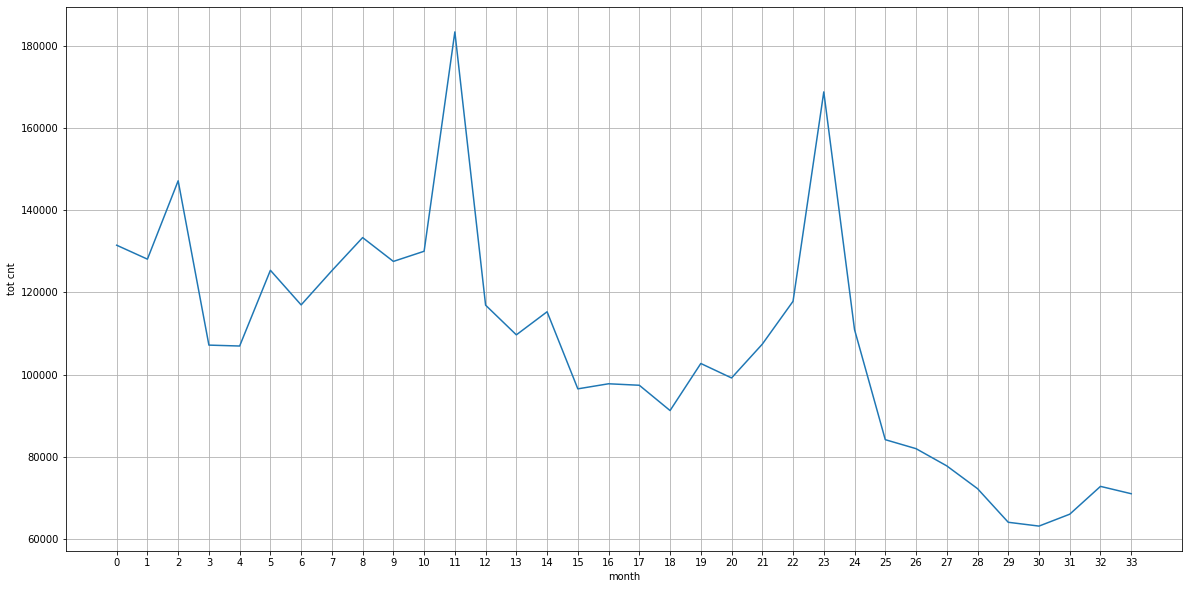

In [26]:
# trend
monthly_sales_tot = sales_train.groupby(["date_block_num"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

s=monthly_sales_tot['item_cnt_day']['sum'].values
t=monthly_sales_tot['item_cnt_day']['sum'].index.values

plt.figure(figsize=(20,10))
plt.plot(t, s)
plt.grid()
plt.xticks(np.arange(len(t)))
plt.xlabel('month')
plt.ylabel('tot cnt')
"Total sales per month"

In [27]:
# w4 assignment copy-paste
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [28]:
# insert test into train

test_with_other_data=test.copy()
test_with_other_data.drop(columns=['ID'])
test_with_other_data['item_cnt_day']=y_pred_trivial
test_with_other_data['item_price']=0
test_with_other_data['date_block_num']=34

sales_train=pd.concat([sales_train, test_with_other_data], axis=0, sort=False)
# sales_train['item_cnt_day'] = np.clip(sales_train['item_cnt_day'], 0, 20)


In [29]:
# w4 assignment copy-paste
sales=sales_train.copy()

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# clip
gb["item_cnt_day"] = np.clip(gb["item_cnt_day"], 0, 20)

# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
# clip
gb["target_shop"] = np.clip(gb["target_shop"], 0, 20)

all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
# clip
gb["target_item"] = np.clip(gb["target_item"], 0, 20)

all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# avg item price
gb = sales.groupby(index_cols,as_index=False).agg({'item_price':{'mean_price':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

#gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_price':{'mean_price_shop':'mean'}})
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

#gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_price':{'mean_price_item':'mean'}})
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
gb = pd.merge(sales, item_category_mapping, how='left', on='item_id')
gb = gb.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_category':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
# clip
gb["target_item_category"] = np.clip(gb["target_item_category"], 0, 20)
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)


#################

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/home/aozeritsky/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [31]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'mean_price', 'item_category_id', 'target_item_category',
       'item_category_id_lag_01', 'mean_price_lag_01', 'target_lag_01',
       'target_item_lag_01', 'target_item_category_lag_01',
       'target_shop_lag_01', 'item_category_id_lag_02', 'mean_price_lag_02',
       'target_lag_02', 'target_item_lag_02', 'target_item_category_lag_02',
       'target_shop_lag_02', 'item_category_id_lag_03', 'mean_price_lag_03',
       'target_lag_03', 'target_item_lag_03', 'target_item_category_lag_03',
       'target_shop_lag_03', 'item_category_id_lag_04', 'mean_price_lag_04',
       'target_lag_04', 'target_item_lag_04', 'target_item_category_lag_04',
       'target_shop_lag_04', 'item_category_id_lag_05', 'mean_price_lag_05',
       'target_lag_05', 'target_item_lag_05', 'target_item_category_lag_05',
       'target_shop_lag_05', 'item_category_id_lag_06', 'mean_price_lag_06',
       'target_lag_06',

In [30]:
# w4 assignment copy-paste
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 6, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{:02d}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-2:] in ["{:02d}".format(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

## item_category_type_mapping = item_categories[['item_category_id', 'item_category_type_id']].drop_duplicates()
## shop_mapping = shops[['shop_id','city_id']].drop_duplicates()

## all_data = pd.merge(all_data, shop_mapping, how='left', on='shop_id')
## all_data = pd.merge(all_data, item_category_type_mapping, how='left', on='item_category_id')
all_data = downcast_dtypes(all_data)
gc.collect();

100%|██████████| 7/7 [01:57<00:00, 19.79s/it]


In [32]:
#items[['item_id','item_category_id', 'item_category_type_id']]
#items.columns
all_data.columns

#index_cols

#fit_cols = [col for col in all_data.columns if col[-2:] in ["{:02d}".format(item) for item in shift_range]] 
#fit_cols

#to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
#to_drop_cols
#["{:02d}".format(item) for item in shift_range]
#for col in all_data.columns:
#    print(col[-1])

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'mean_price', 'item_category_id', 'target_item_category',
       'item_category_id_lag_01', 'mean_price_lag_01', 'target_lag_01',
       'target_item_lag_01', 'target_item_category_lag_01',
       'target_shop_lag_01', 'item_category_id_lag_02', 'mean_price_lag_02',
       'target_lag_02', 'target_item_lag_02', 'target_item_category_lag_02',
       'target_shop_lag_02', 'item_category_id_lag_03', 'mean_price_lag_03',
       'target_lag_03', 'target_item_lag_03', 'target_item_category_lag_03',
       'target_shop_lag_03', 'item_category_id_lag_04', 'mean_price_lag_04',
       'target_lag_04', 'target_item_lag_04', 'target_item_category_lag_04',
       'target_shop_lag_04', 'item_category_id_lag_05', 'mean_price_lag_05',
       'target_lag_05', 'target_item_lag_05', 'target_item_category_lag_05',
       'target_shop_lag_05', 'item_category_id_lag_06', 'mean_price_lag_06',
       'target_lag_06',

In [100]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,mean_price,mean_price_shop,mean_price_item,item_category_id,...,target_item_category_lag_11,target_shop_lag_11,item_category_id_lag_12,mean_price_lag_12,mean_price_item_lag_12,mean_price_shop_lag_12,target_lag_12,target_item_lag_12,target_item_category_lag_12,target_shop_lag_12
4488756,54,10297,12,4.0,20.0,20.0,749.0,696.495422,749.000000,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,54,10296,12,3.0,20.0,17.0,1599.0,696.495422,1569.647095,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,54,10298,12,14.0,20.0,20.0,399.0,696.495422,394.649353,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,54,10300,12,3.0,20.0,20.0,699.0,696.495422,699.000000,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,54,10284,12,1.0,20.0,3.0,299.0,696.495422,299.000000,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
print(all_data.columns)
print(to_drop_cols)

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'mean_price', 'mean_price_shop', 'mean_price_item',
       'item_category_id',
       ...
       'target_item_category_lag_11', 'target_shop_lag_11',
       'item_category_id_lag_12', 'mean_price_lag_12',
       'mean_price_item_lag_12', 'mean_price_shop_lag_12', 'target_lag_12',
       'target_item_lag_12', 'target_item_category_lag_12',
       'target_shop_lag_12'],
      dtype='object', length=107)
['target_item', 'target_shop', 'target_item_category', 'mean_price_item', 'mean_price_shop', 'mean_price', 'item_category_id', 'target', 'date_block_num']


In [33]:
import gensim
from gensim import corpora
from gensim import models
from scipy.sparse import csr_matrix

def texts_vectorizer(raw_texts, dim=100, init_vectorizer=False):   
    texts = []
    for line in raw_texts:
        line_preprocessed = gensim.utils.simple_preprocess(line)
        #print(line_preprocessed)
        texts.append(line_preprocessed)
    
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(line) for line in texts] 
    
    # count vectorizer
    
#    data = []
#    indices = дальнейшем[]
#    indptr = [0]
    
#    for doc in corpus:
#        for index,count in doc:
#            indices.append(index)
#            data.append(count)
#        indptr.append(len(indices))
#    
#    corpus_count = csr_matrix((data, indices, indptr), dtype=int)
#    corpus_count = gensim.matutils.Sparse2Corpus(corpus_count, documents_columns=False)

    corpus_count = corpus
    lsi = models.LsiModel(corpus_count, id2word=dictionary, num_topics=dim)
    corpus_lsi = lsi[corpus_count]

    # tf-idf vectorizer
#    tfidf = models.TfidfModel(corpus)    
#    corpus_tfidf = tfidf[corpus]
#    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dim)
#    corpus_lsi = lsi[corpus_tfidf]

    all_topics_csr = gensim.matutils.corpus2csc(corpus_lsi)
    all_topics_numpy = all_topics_csr.T.toarray()
    
    return all_topics_numpy

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
texts=["aaa aaa cc", "aaa cc bb", "gg ee ff", "ee ee ee"]
#dictionary = corpora.Dictionary(texts)
#corpus = [dictionary.doc2bow(line) for line in texts] 

#print(corpus)

# vect = CountVectorizer(min_df=1, ngram_range=(1, 1), max_features=25000)
# corpus_vect = vect.fit_transform(texts)
# print(type(corpus_vect))
# print(corpus_vect)
# print(corpus_vect.toarray())

texts_vectorizer(texts)

array([[ 0.        ,  2.17108138,  0.        ,  0.53516879],
       [ 0.        ,  1.56482692,  0.        , -0.74250704],
       [ 1.22474487,  0.        , -1.22474487,  0.        ],
       [ 2.95679568,  0.        ,  0.50730594,  0.        ]])

In [37]:
# X.head()

In [35]:
rich_items = pd.merge(left=items, right=item_categories, on='item_category_id')
rich_items["rich_item"] = rich_items.item_name + " " + rich_items.item_category_name
rich_items = rich_items[['item_id', 'rich_item']]
item_vectors = texts_vectorizer(rich_items.rich_item, 16)
rich_items = pd.concat([rich_items, pd.DataFrame(item_vectors).add_prefix('i')], axis=1, sort=False)
rich_items = rich_items.drop(columns=['rich_item'])
#rich_items.head()

shop_vectors = texts_vectorizer(shops.shop_name, 4)
rich_shops = pd.concat([shops, pd.DataFrame(shop_vectors).add_prefix('s')], axis=1, sort=False)
## rich_shops = rich_shops.drop(columns=['shop_name', "city_id", "city_name"])
rich_shops = rich_shops.drop(columns=['shop_name'])

X=all_data.copy()
# X.head()

X = pd.merge(left=X, right=rich_items, on='item_id', how='left', sort=False)
X = pd.merge(left=X, right=rich_shops, on='shop_id', how='left', sort=False)

X = downcast_dtypes(X)

# all_data=X
X.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,mean_price,item_category_id,target_item_category,item_category_id_lag_01,...,i10,i11,i12,i13,i14,i15,s0,s1,s2,s3
0,54,10297,12,4.0,20.0,20.0,749.0,37,20.0,37.0,...,-0.004398,0.010923,0.003313,0.000555,0.004839,-0.015131,1.147552,-0.012065,0.381713,0.073677
1,54,10296,12,3.0,20.0,17.0,1599.0,38,20.0,38.0,...,-0.004398,0.010923,0.003313,0.000555,0.004839,-0.015131,1.147552,-0.012065,0.381713,0.073677
2,54,10298,12,14.0,20.0,20.0,399.0,40,20.0,40.0,...,0.000669,-0.005875,0.005159,-0.005394,0.104316,0.229311,1.147552,-0.012065,0.381713,0.073677
3,54,10300,12,3.0,20.0,20.0,699.0,37,20.0,37.0,...,-0.004398,0.010923,0.003313,0.000555,0.004839,-0.015131,1.147552,-0.012065,0.381713,0.073677
4,54,10284,12,1.0,20.0,3.0,299.0,57,20.0,57.0,...,0.324828,-1.022657,-0.006452,-0.068163,-0.023069,-0.020184,1.147552,-0.012065,0.381713,0.073677


In [39]:
#for col in X.columns:
#    print(col)

In [36]:
dates = X['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

# dates.head(100)

Test `date_block_num` is 34


In [41]:
X[all_data.date_block_num == 23].head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,mean_price,mean_price_shop,mean_price_item,mean_price_lag_01,...,i10,i11,i12,i13,i14,i15,s0,s1,s2,s3
3609267,42,17279,23,3.0,20.0,20.0,271.833344,1363.17334,258.164612,299.000000,...,-0.004267,0.010936,0.003855,0.001572,0.005563,-0.016522,0.031316,-0.025925,-0.421538,-0.162201
3609268,42,17315,23,11.0,20.0,20.0,399.000000,1363.17334,394.198761,0.000000,...,0.000735,-0.005567,0.005731,-0.004377,0.105740,0.228728,0.031316,-0.025925,-0.421538,-0.162201
3609269,42,17302,23,7.0,20.0,20.0,149.000000,1363.17334,143.770584,149.000000,...,-0.004612,0.010819,0.004175,0.002663,0.004470,-0.015064,0.031316,-0.025925,-0.421538,-0.162201
3609270,42,17717,23,20.0,20.0,20.0,1507.989746,1363.17334,1313.146118,1259.466919,...,-0.269050,0.178783,0.075536,0.056375,0.018991,-0.129368,0.031316,-0.025925,-0.421538,-0.162201
3609271,42,17322,23,2.0,20.0,20.0,149.000000,1363.17334,149.000000,0.000000,...,0.001470,-0.064844,-0.025550,-0.020445,-0.258847,-0.518938,0.031316,-0.025925,-0.421538,-0.162201


In [37]:
# uncomment to exclude test data
last_block = 33

to_drop_nn = ["shop_id", "item_id", "item_category_id"]
# to_drop_nn = ["shop_id", "item_id", "item_category_id", "item_category_type_id", "city_id"]
# to_drop_nn = ["shop_id", "item_id"]
# to_drop_cols = to_drop_cols

dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = X.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  X.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = X.loc[dates <  last_block, 'target'].values
y_test =  X.loc[dates == last_block, 'target'].values

X_test2 =  X.loc[dates == 34].drop(to_drop_cols, axis=1)
y_test2 =  X.loc[dates == 34, 'target'].values

y_train = np.clip(y_train, 0, 20)
y_test = np.clip(y_test, 0, 20)
y_test2 = np.clip(y_test2, 0, 20)

In [106]:
X_test.head()

,shop_id,item_id,item_category_id_lag_01,mean_price_lag_01,mean_price_item_lag_01,mean_price_shop_lag_01,target_lag_01,target_item_lag_01,target_item_category_lag_01,target_shop_lag_01,...,i10,i11,i12,i13,i14,i15,s0,s1,s2,s3
6186922,45,13315,47.0,0.0,649.000000,1290.294678,0.0,1.0,20.0,20.0,...,0.051027,0.519494,0.001892,0.058581,-0.035568,-0.036011,0.972379,-0.012393,0.411217,-0.02689
6186923,45,13880,55.0,0.0,225.037033,1290.294678,0.0,20.0,20.0,20.0,...,-0.405092,0.170024,-0.029798,0.119207,-0.220017,-0.055184,0.972379,-0.012393,0.411217,-0.02689
6186924,45,13881,55.0,659.0,647.991211,1290.294678,1.0,20.0,20.0,20.0,...,-0.196679,0.056114,0.285793,-0.111776,0.534065,-0.226302,0.972379,-0.012393,0.411217,-0.02689
6186925,45,13923,40.0,0.0,158.952667,1290.294678,0.0,15.0,20.0,20.0,...,0.001472,-0.064861,-0.025564,-0.020334,-0.258870,-0.518788,0.972379,-0.012393,0.411217,-0.02689
6186926,45,14227,30.0,0.0,95.542320,1290.294678,0.0,20.0,20.0,20.0,...,-0.776479,0.585991,-0.218332,-0.263914,-0.275602,-0.087753,0.972379,-0.012393,0.411217,-0.02689


In [107]:
X_train.columns

Index(['shop_id', 'item_id', 'item_category_id_lag_01', 'mean_price_lag_01',
       'mean_price_item_lag_01', 'mean_price_shop_lag_01', 'target_lag_01',
       'target_item_lag_01', 'target_item_category_lag_01',
       'target_shop_lag_01',
       ...
       'i10', 'i11', 'i12', 'i13', 'i14', 'i15', 's0', 's1', 's2', 's3'],
      dtype='object', length=118)

In [60]:
import catboost
from catboost import CatBoostRegressor

cat_feature_columns=to_drop_nn

#cat_feature_columns=[]
#cat_feature_columns=["shop_id", "item_id", "item_category_id"]
#cat_feature_columns=["shop_id"]
cat_features=[]
for col in cat_feature_columns:
    cat_features.append(X_train.columns.get_loc(col))
print(cat_features)
catboost_model = CatBoostRegressor(
    iterations=300,
    verbose=3,
    random_seed=49,
    learning_rate=0.05,
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
)
catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
)

[0, 1, 74]
0:	learn: 1.1674172	test: 1.1218834	best: 1.1218834 (0)	total: 849ms	remaining: 4m 13s
3:	learn: 1.1134105	test: 1.0849411	best: 1.0849411 (3)	total: 2.99s	remaining: 3m 41s
6:	learn: 1.0710117	test: 1.0560664	best: 1.0560664 (6)	total: 5.01s	remaining: 3m 29s
9:	learn: 1.0376553	test: 1.0338771	best: 1.0338771 (9)	total: 7.1s	remaining: 3m 25s
12:	learn: 1.0110714	test: 1.0167619	best: 1.0167619 (12)	total: 9.14s	remaining: 3m 21s
15:	learn: 0.9899059	test: 1.0021096	best: 1.0021096 (15)	total: 11.2s	remaining: 3m 18s
18:	learn: 0.9703810	test: 0.9918640	best: 0.9918640 (18)	total: 13.6s	remaining: 3m 20s
21:	learn: 0.9540440	test: 0.9825874	best: 0.9825874 (21)	total: 16s	remaining: 3m 21s
24:	learn: 0.9296938	test: 0.9771354	best: 0.9771354 (24)	total: 19.3s	remaining: 3m 32s
27:	learn: 0.9074339	test: 0.9763096	best: 0.9763096 (27)	total: 22.7s	remaining: 3m 40s
30:	learn: 0.8907403	test: 0.9771201	best: 0.9763096 (27)	total: 24.9s	remaining: 3m 35s
33:	learn: 0.8750690	

In [ ]:
catboost_model.best_score_

In [ ]:
y_pred = catboost_model.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))
# make_submission2(X_test, y_pred, test, 'submission_3.csv')

In [ ]:
y_pred2 = catboost_model.predict(X_test2)
# make_submission(y_pred2, test.ID, 'submission_3.csv')
make_submission2(X_test2, y_pred2, test, 'submission_3.csv')
print(math.sqrt(mean_squared_error(y_test2, y_pred2)))

In [ ]:
y_pred2.sum()

In [53]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.8,
                 #gamma=0,                 
                 learning_rate=0.05,
                 max_depth=15,
                 #min_child_weight=1.5,
                 min_child_weight=50, # was 10
                 n_estimators=400,
                 #reg_alpha=0.95,
                 #reg_lambda=0.55,
                 subsample=0.7,
                 seed=42,
                 verbosity=1,
                 n_jobs=-1)

xgb_model.fit(X_train, 
          y_train, 
          eval_metric="rmse", 
          verbose=True, 
          early_stopping_rounds=10, 
          eval_set=[(X_train, y_train), (X_test, y_test)])

[16:10:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.17582	validation_1-rmse:1.13892
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14665	validation_1-rmse:1.11719
[2]	validation_0-rmse:1.12045	validation_1-rmse:1.09808
[3]	validation_0-rmse:1.09497	validation_1-rmse:1.07895
[4]	validation_0-rmse:1.07093	validation_1-rmse:1.06076
[5]	validation_0-rmse:1.04844	validation_1-rmse:1.04571
[6]	validation_0-rmse:1.029	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=15, min_child_weight=50, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.7, verbosity=1)

In [48]:
gc.collect()

60

In [56]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


param_grid = {
        'n_estimators':[100], 
        'min_child_weight': [50, 100],
        'max_depth':[5, 10],
        'subsample': [0.5, 0.8]
}

clf = GridSearchCV(xgboost.XGBRegressor(learning_rate=0.05, 
                                        colsample_bytree=0.8, 
                                        seed=42,
                                        tree_method='hist',
                                        n_jobs=-1, verbosity=1), 
                   param_grid=param_grid, n_jobs=1,
                   scoring='neg_mean_squared_error',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7, return_train_score=True)


clf.fit(X_train, 
          y_train, 
          eval_metric="rmse", 
          verbose=True, 
          early_stopping_rounds=10, 
          eval_set=[(X_train, y_train), (X_test, y_test)])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.5 
[14:16:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18292	validation_1-rmse:1.14347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16545	validation_1-rmse:1.12867
[2]	validation_0-rmse:1.14388	validation_1-rmse:1.11325
[3]	validation_0-rmse:1.12532	validation_1-rmse:1.09909
[4]	validation_0-rmse:1.10825	validation_1-rmse:1.08639
[5]	validation_0-rmse:1.09188	validation_1-rmse:1.07485
[6]	validation_0-rmse:1.07695	validation_1-rmse:1.06398
[7]	validation_0-rmse:1.06474	validation_1-rmse:1.05491
[8]	validation_0-rmse:1.05211	validation_1-rmse:1.0456
[9]	validation_0-rmse:1.04178	validation_1-rmse:1.03812
[10]	validation_0-rmse:1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.5 
[14:17:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18309	validation_1-rmse:1.14341
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16516	validation_1-rmse:1.1288
[2]	validation_0-rmse:1.14352	validation_1-rmse:1.11326
[3]	validation_0-rmse:1.12472	validation_1-rmse:1.09902
[4]	validation_0-rmse:1.10771	validation_1-rmse:1.08639
[5]	validation_0-rmse:1.09189	validation_1-rmse:1.0747
[6]	validation_0-rmse:1.0765	validation_1-rmse:1.06393
[7]	validation_0-rmse:1.06469	validation_1-rmse:1.05488
[8]	validation_0-rmse:1.05215	validation_1-rmse:1.04577
[9]	validation_0-rmse:1.04189	validation_1-rmse:1.03834
[10]	validation_0-rmse:1.0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.5 
[14:18:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18291	validation_1-rmse:1.14366
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1655	validation_1-rmse:1.12911
[2]	validation_0-rmse:1.14383	validation_1-rmse:1.1134
[3]	validation_0-rmse:1.1254	validation_1-rmse:1.09924
[4]	validation_0-rmse:1.10776	validation_1-rmse:1.08647
[5]	validation_0-rmse:1.09149	validation_1-rmse:1.07476
[6]	validation_0-rmse:1.0766	validation_1-rmse:1.06392
[7]	validation_0-rmse:1.06469	validation_1-rmse:1.05487
[8]	validation_0-rmse:1.05231	validation_1-rmse:1.04586
[9]	validation_0-rmse:1.04181	validation_1-rmse:1.03822
[10]	validation_0-rmse:1.03

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.8 
[14:20:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18288	validation_1-rmse:1.14343
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16532	validation_1-rmse:1.12877
[2]	validation_0-rmse:1.14373	validation_1-rmse:1.11338
[3]	validation_0-rmse:1.12486	validation_1-rmse:1.09918
[4]	validation_0-rmse:1.1079	validation_1-rmse:1.08662
[5]	validation_0-rmse:1.0917	validation_1-rmse:1.07509
[6]	validation_0-rmse:1.07673	validation_1-rmse:1.06439
[7]	validation_0-rmse:1.06465	validation_1-rmse:1.05541
[8]	validation_0-rmse:1.052	validation_1-rmse:1.04606
[9]	validation_0-rmse:1.04155	validation_1-rmse:1.03835
[10]	validation_0-rmse:1.03

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.1min remaining:    0.0s


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.8 
[14:21:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18289	validation_1-rmse:1.14345
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16516	validation_1-rmse:1.12862
[2]	validation_0-rmse:1.1436	validation_1-rmse:1.11314
[3]	validation_0-rmse:1.12513	validation_1-rmse:1.09906
[4]	validation_0-rmse:1.10769	validation_1-rmse:1.08643
[5]	validation_0-rmse:1.09147	validation_1-rmse:1.07469
[6]	validation_0-rmse:1.07647	validation_1-rmse:1.06389
[7]	validation_0-rmse:1.06454	validation_1-rmse:1.05459
[8]	validation_0-rmse:1.05198	validation_1-rmse:1.04553
[9]	validation_0-rmse:1.04163	validation_1-rmse:1.038
[10]	validation_0-rmse:1.0

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min remaining:    0.0s


[CV] max_depth=5, min_child_weight=50, n_estimators=100, subsample=0.8 
[14:22:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.1829	validation_1-rmse:1.1438
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16525	validation_1-rmse:1.12906
[2]	validation_0-rmse:1.14366	validation_1-rmse:1.1135
[3]	validation_0-rmse:1.12483	validation_1-rmse:1.09924
[4]	validation_0-rmse:1.10777	validation_1-rmse:1.08665
[5]	validation_0-rmse:1.09194	validation_1-rmse:1.07479
[6]	validation_0-rmse:1.07625	validation_1-rmse:1.0637
[7]	validation_0-rmse:1.06442	validation_1-rmse:1.05448
[8]	validation_0-rmse:1.05208	validation_1-rmse:1.04543
[9]	validation_0-rmse:1.04152	validation_1-rmse:1.03792
[10]	validation_0-rmse:1.03

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.6min remaining:    0.0s


[CV] max_depth=5, min_child_weight=100, n_estimators=100, subsample=0.5 
[14:23:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18295	validation_1-rmse:1.14352
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16547	validation_1-rmse:1.12858
[2]	validation_0-rmse:1.1439	validation_1-rmse:1.11301
[3]	validation_0-rmse:1.12533	validation_1-rmse:1.09882
[4]	validation_0-rmse:1.10825	validation_1-rmse:1.08611
[5]	validation_0-rmse:1.09189	validation_1-rmse:1.07457
[6]	validation_0-rmse:1.077	validation_1-rmse:1.06386
[7]	validation_0-rmse:1.06481	validation_1-rmse:1.0548
[8]	validation_0-rmse:1.05217	validation_1-rmse:1.04548
[9]	validation_0-rmse:1.04182	validation_1-rmse:1.03794
[10]	validation_0-rmse:1.0

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 35.3min finished


[14:51:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.17939	validation_1-rmse:1.14063
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15572	validation_1-rmse:1.12218
[2]	validation_0-rmse:1.1314	validation_1-rmse:1.10433
[3]	validation_0-rmse:1.1093	validation_1-rmse:1.08829
[4]	validation_0-rmse:1.08896	validation_1-rmse:1.07377
[5]	validation_0-rmse:1.06985	validation_1-rmse:1.06025
[6]	validation_0-rmse:1.05201	validation_1-rmse:1.04762
[7]	validation_0-rmse:1.03679	validation_1-rmse:1.03651
[8]	validation_0-rmse:1.0213	validation_1-rmse:1.02588
[9]	validation_0-rmse:1.0081	validation_1-rmse:1.01635
[10]	validation_0-rmse:0.994727	validation_1-rmse:1.00699
[11]	validation_0-rmse:0.982347	validatio

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_j...
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=1, tree_method='hist',
                                    verbosity=1),
             iid='warn', n_jobs=1,
             par

In [57]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=50, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, tree_method='hist', verbosity=1)

In [40]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
gc.collect()
# xgb_model = clf.best_estimator_
# xgb_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
#             importance_type='gain', learning_rate=0.05, max_delta_step=0,
#             max_depth=10, min_child_weight=50, missing=None, n_estimators=100,
#             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
#             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
#             silent=None, subsample=0.8, tree_method='hist', verbosity=1) # <- best_estimator_
# reg:squarederror ?

## try to get clf.best_estimator_ with a little bit more n_estimators
xgb_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=80,
             n_jobs=-1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, tree_method='hist', verbosity=1)

xgb_model.fit(X_train, 
          y_train, 
          eval_metric="rmse", 
          verbose=True, 
          early_stopping_rounds=10, 
          eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:1.17589	validation_1-rmse:1.13953
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14966	validation_1-rmse:1.11977
[2]	validation_0-rmse:1.12249	validation_1-rmse:1.10059
[3]	validation_0-rmse:1.09949	validation_1-rmse:1.08516
[4]	validation_0-rmse:1.07525	validation_1-rmse:1.06909
[5]	validation_0-rmse:1.05264	validation_1-rmse:1.05385
[6]	validation_0-rmse:1.03169	validation_1-rmse:1.04118
[7]	validation_0-rmse:1.01181	validation_1-rmse:1.0286
[8]	validation_0-rmse:0.994104	validation_1-rmse:1.0174
[9]	validation_0-rmse:0.976963	validation_1-rmse:1.0078
[10]	validation_0-rmse:0.961146	validation_1-rmse:0.99819
[11]	validation_0-rmse:0.946183	validation_1-rmse:0.989319
[12]	validation_0-rmse:0.933181	validation_1-rmse:0.980113
[13]	validation_0-rmse:0.920001	validation_1-rmse:0.972708
[14]	validation_0-rmse:0.90804	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=80,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, tree_method='hist',
             verbosity=1)

In [51]:
X_train.columns[np.argsort(-1.0*xgb_model.feature_importances_)]
#np.argsort(xgb_model.feature_importances_)
#xgb_model.feature_importances_

Index(['target_lag_01', 'target_shop_lag_02', 'target_item_category_lag_05',
       'target_shop_lag_12', 'target_item_category_lag_03',
       'target_item_category_lag_01', 'target_item_category_lag_02',
       'target_item_category_lag_12', 'target_shop_lag_01', 'target_lag_02',
       'item_category_id_lag_12', 'target_item_lag_01',
       'item_category_id_lag_02', 'target_item_category_lag_04',
       'target_lag_03', 'item_category_id_lag_03', 'i13', 'i1',
       'item_category_id_lag_06', 'i7', 'i2', 'target_shop_lag_04', 'i3',
       'item_category_id_lag_01', 'i8', 'i4', 'target_lag_06', 'i6', 'i11',
       'mean_price_lag_01', 'i12', 'item_category_id_lag_05', 'i15',
       'target_lag_04', 'target_shop_lag_06', 'i14', 'i9', 'i10',
       'item_category_id_lag_04', 'i5', 'i0', 'target_lag_05', 's1', 's3',
       'target_item_lag_02', 'target_item_category_lag_06', 'item_id',
       'target_shop_lag_05', 's2', 'mean_price_lag_02', 'target_lag_12', 's0',
       'mean_price_lag

In [52]:
#xgb_model = clf.best_estimator_
#y_pred2 = xgb_model.predict(X_test2) # <- # 0.919094 and 0.933055 <- Passed!

# xgb_model = clf.best_estimator_
y_pred2 = xgb_model.predict(X_test2) # <- 0.901446 and 0.915727.

# make_submission(y_pred2, test.ID, 'submission_3.csv')
make_submission2(X_test2, y_pred2, test, 'submission_3.csv')
print(math.sqrt(mean_squared_error(y_test2, y_pred2)))

0.5094034362531791


In [58]:
lr_pred = lr_model.predict(X_test)
# catboost_pred = catboost_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

lr_pred2 = lr_model.predict(X_test2)
# catboost_pred2 = catboost_model.predict(X_test2)
xgb_pred2 = xgb_model.predict(X_test2)

#X_test_level2 = np.c_[lr_pred, catboost_pred, xgb_pred] 
#X_test2_level2 = np.c_[lr_pred2, catboost_pred2, xgb_pred2] 

X_test_level2 = np.c_[lr_pred, xgb_pred] 
X_test2_level2 = np.c_[lr_pred2, xgb_pred2] 

In [84]:
dates_train.unique().min()

12

In [59]:
level2_blocks = [26, 27, 28, 29, 30, 31, 32]

dates_train_level2 = dates_train[dates_train.isin(level2_blocks)]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(level2_blocks)]

start_index = dates_train_level2.index[0]

print(start_index)

#print(cat_features)

#print(X_train_level2.shape)

#dates_train_level2.index[dates_train_level2 == 27]
#dates_train_level2.index

#print("shapes")
#print(X_train_level2.shape)
#print(dates_train_level2.shape)

4530958


In [60]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in level2_blocks:
    
    print(cur_block_num)
       
    #  YOUR CODE GOES HERE
    _X_train = X.loc[dates <  cur_block_num].drop(columns=to_drop_cols)
    _X_test =  X.loc[dates == cur_block_num].drop(columns=to_drop_cols)

    _y_train = X.loc[dates <  cur_block_num, 'target'].values
    _y_test = X.loc[dates ==  cur_block_num, 'target'].values
    
    lr_model.fit(_X_train, _y_train)
    lr_pred = lr_model.predict(_X_test)
    
#    catboost_model.fit(_X_train, _y_train, eval_set=(_X_test, _y_test))
#    catboost_pred = catboost_model.predict(_X_test)
    
    xgb_model.fit(_X_train, _y_train, 
                  eval_metric="rmse", 
                  verbose=True, 
                  early_stopping_rounds=10, 
                  eval_set=[(_X_train, _y_train), (_X_test, _y_test)])
    xgb_pred = xgb_model.predict(_X_test)
    
    indexes = dates_train_level2.index[dates_train_level2 == cur_block_num]
    
    for i in range(xgb_pred.shape[0]):
        X_train_level2[indexes[i] - start_index] = [lr_pred[i], xgb_pred[i]]     
#        X_train_level2[indexes[i] - start_index] = [lr_pred[i], catboost_pred[i], xgb_pred[i]]     

26
[0]	validation_0-rmse:1.2098	validation_1-rmse:1.07536
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.18176	validation_1-rmse:1.05102
[2]	validation_0-rmse:1.15319	validation_1-rmse:1.02694
[3]	validation_0-rmse:1.12883	validation_1-rmse:1.0045
[4]	validation_0-rmse:1.10293	validation_1-rmse:0.98368
[5]	validation_0-rmse:1.07887	validation_1-rmse:0.963919
[6]	validation_0-rmse:1.05614	validation_1-rmse:0.945896
[7]	validation_0-rmse:1.03511	validation_1-rmse:0.930309
[8]	validation_0-rmse:1.01555	validation_1-rmse:0.916332
[9]	validation_0-rmse:0.99694	validation_1-rmse:0.902808
[10]	validation_0-rmse:0.98014	validation_1-rmse:0.890785
[11]	validation_0-rmse:0.96433	validation_1-rmse:0.879515
[12]	validation_0-rmse:0.949901	validation_1-rmse:0.869648
[13]	validation_0-rmse:0.935838	validation_1-rmse:0.860264
[14]	validation_0-rmse:0.92281	validation

In [61]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()

meta_model.fit(X_train_level2, y_train_level2)

#meta_model = xgboost.XGBRegressor(colsample_bytree=0.8,
#                 #gamma=0,                 
#                 learning_rate=0.05,
#                 max_depth=15,
#                 #min_child_weight=1.5,
#                 min_child_weight=50, # was 10
#                 n_estimators=150,
#                 #reg_alpha=0.95,
#                 #reg_lambda=0.55,
#                 subsample=0.7,
#                 seed=42,
#                 verbosity=1,
#                 n_jobs=-1)

#meta_model.fit(X_train_level2, 
#          y_train_level2, 
#          eval_metric="rmse", 
#          verbose=True, 
#          early_stopping_rounds=10, 
#          eval_set=[(X_test_level2, test_preds)])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
test_preds = meta_model.predict(X_test_level2)
test_preds2 = meta_model.predict(X_test2_level2)

make_submission2(X_test2, test_preds2, test, 'submission_4.csv')

print(math.sqrt(mean_squared_error(y_test, test_preds)))
print(math.sqrt(mean_squared_error(y_test2, test_preds2)))

0.8841266167609174
0.46099410216990977


In [93]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import optimizers

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.drop(columns=to_drop_nn).shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1, kernel_initializer='normal'))
    #loss = 'mean_squared_error'
    проводнуюoptimizer = optimizers.RMSprop()    
    loss = root_mean_squared_error
   
    model.compile(loss=loss, optimizer=optimizer)
    
    return model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=to_drop_nn))
X_test_scaled = scaler.transform(X_test.drop(columns=to_drop_nn))

model = KerasRegressor(build_fn=baseline_model, 
                          epochs=10000, 
                          batch_size=60000, 
                          verbose=1, 
                          validation_data=(X_test_scaled, y_test))

model.fit(X_train_scaled, y_train)

W1130 23:03:38.463551 139748287362880 deprecation_wrapper.py:119] From /home/aozeritsky/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1130 23:03:40.387257 139748287362880 deprecation_wrapper.py:119] From /home/aozeritsky/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1130 23:03:40.390938 139748287362880 deprecation_wrapper.py:119] From /home/aozeritsky/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1130 23:03:40.401778 139748287362880 deprecation_wrapper.py:119] From /home/aozeritsky/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compa

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10000
6186922/6186922 [==============================] - 68s 11us/step - loss: 0.9315 - val_loss: 0.9363
Epoch 2/10000
6186922/6186922 [==============================] - 68s 11us/step - loss: 0.8953 - val_loss: 0.9159
Epoch 3/10000
6186922/6186922 [==============================] - 66s 11us/step - loss: 0.8864 - val_loss: 0.9244
Epoch 4/10000
6186922/6186922 [==============================] - 67s 11us/step - loss: 0.8814 - val_loss: 0.9176
Epoch 5/10000
6186922/6186922 [==============================] - 67s 11us/step - loss: 0.8783 - val_loss: 0.9195
Epoch 6/10000
6186922/6186922 [==============================] - 67s 11us/step - loss: 0.8758 - val_loss: 0.9201
Epoch 7/10000
2100000/6186922 [=========>....................] - ETA: 43s - loss: 0.8771

KeyboardInterrupt: 

In [ ]:
# X_train.iloc[:,35:].head()
# X_train.shape[1]
gc.collect()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import optimizers


from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model

from keras import optimizers

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train.drop(columns=to_drop_nn).values
X_test_scaled = X_test.drop(columns=to_drop_nn).values

#print(X_train.columns)
i = 0
for column in X_train.drop(columns=to_drop_nn).columns:
    if not "_lag_" in column:
        #print(column)
        break
    i = i + 1    
#print(i)
#print(X_train.columns[i])

assert(i == 3*len(shift_range))

n_features=3
periods=len(shift_range)

bases=['target_lag', 
      'target_item_lag', 
      'target_shop_lag']

X1_train=np.zeros((X_train_scaled.shape[0], periods, n_features), dtype='float32')
X1_test=np.zeros((X_test_scaled.shape[0], periods, n_features), dtype='float32')
X1_test2=np.zeros((X_test2.shape[0], periods, n_features), dtype='float32')

feature_no = 0
for base in bases:
    columns=[]
    
    for period in shift_range:
        columns.append("{}_{:02}".format(base, period))
    

    X1_train[:,:,feature_no]=X_train[columns].values.astype('float32')   
    X1_test[:,:,feature_no]=X_test[columns].values.astype('float32')
    X1_test2[:,:,feature_no]=X_test2[columns].values.astype('float32')

    feature_no = feature_no+1

# X1_train.shape

# X2_train=X_train.iloc[:,i:]
# X2_test=X_test.iloc[:,i:]

X2_train=X_train_scaled[:,i:]
X2_test=X_test_scaled[:,i:]
X2_test2=X_test2.iloc[:,i:]

lag_input = Input(shape=(periods, n_features))
lstm = LSTM(16, activation='relu')(lag_input)

dense_input = Input(shape=(X2_train.shape[1],))
dense = Dense(16, activation='relu')(dense_input)

merger = concatenate([lstm, dense])

dense_inner = Dense(8, activation='relu')(merger)
dense_output = Dense(1)(dense_inner)

model = Model(inputs=[lag_input, dense_input], outputs=dense_output)

optimizer=optimizers.SGD(lr=0.05, clipnorm=5.)
loss = root_mean_squared_error
# loss='mean_squared_error'

model.compile(loss=loss,
              optimizer=optimizer) # ,
              # metrics=['accuracy', 'mean_squared_error'])


In [ ]:
model.fit([X1_train,X2_train], y_train, epochs=20, batch_size=10000, verbose=1, validation_data=([X1_test,X2_test], y_test))

In [ ]:
y_pred=model.predict([X1_test,X2_test])
print(math.sqrt(mean_squared_error(y_test, y_pred)))